In [16]:
from neuron import h, gui
import os
import matplotlib.pyplot as plt
import numpy as np

In [17]:
h.load_file("mosinit.hoc")

1.0

	-66.569043 


In [3]:
def psection(sec):
    from neuron import h
    try:
        from neuron import rxd
        from neuron.rxd import region, species
        from neuron.rxd import rxd as rxd_module
        have_rxd = True
    except:
      have_rxd = False

    results = {}

    mname = h.ref('')

    # point processes
    pps = {}
    mt = h.MechanismType(1)
    for i in range(int(mt.count())):
        mt.select(i)
        mypps = set()
        pp = mt.pp_begin(sec=sec)
        while pp is not None:
            mypps.add(pp)
            pp = mt.pp_next()
        if mypps:
            mt.selected(mname)
            pps[mname[0]] = mypps
    results['point_processes'] = pps

    center_seg_dir = dir(sec(0.5))

    mechs_present = []

    # membrane mechanisms
    mt = h.MechanismType(0)

    for i in range(int(mt.count())):
        mt.select(i)
        mt.selected(mname)
        name = mname[0]
        if name in center_seg_dir:
            mechs_present.append(name)

    results['density_mechs'] = {}
    results['ions'] = {}

    for mech in mechs_present:
        my_results = {}
        ms = h.MechanismStandard(mech, 3) # <------------------
        for j in range(int(ms.count())):
            n = int(ms.name(mname, j))
            name = mname[0]
            pvals = []
            # TODO: technically this is assuming everything that ends with _ion
            #       is an ion. Check this.
            if mech.endswith('_ion'):
                pvals = [getattr(seg, name) for seg in sec]
            else:
                mechname = name#+ '_' + mech
                for seg in sec:
                    if n > 1:
                        pvals.append([getattr(seg, mechname)[i] for i in range(n)])
                    else:
                        pvals.append(getattr(seg, mechname))
            my_results[name[:-(len(mech) + 1)] if name.endswith('_' + mech) else name] = pvals
        # TODO: should be a better way of testing if an ion
        if mech.endswith('_ion'):
            results['ions'][mech[:-4]] = my_results
        else:
            results['density_mechs'][mech] = my_results

    morphology = {'L': sec.L,
                  'diam': [seg.diam for seg in sec],
                  'pts3d': [(sec.x3d(i), sec.y3d(i), sec.z3d(i), sec.diam3d(i)) for i in range(sec.n3d())],
                  'parent': sec.parentseg(),
                  'trueparent': sec.trueparentseg()}

    results['morphology'] = morphology
    results['nseg'] = sec.nseg
    results['Ra'] = sec.Ra
    results['cm'] = [seg.cm for seg in sec]

    if have_rxd:
        regions = {r() for r in region._all_regions if r() is not None and sec in r().secs}
        results['regions'] = regions

        my_species = []
        for sp in species._all_species:
            sp = sp()
            if sp is not None:
                sp_regions = sp._regions
                if not hasattr(sp_regions, '__len__'):
                    sp_regions = [sp_regions]
                if any(r in sp_regions for r in regions):
                    my_species.append(sp)
        results['species'] = set(my_species)
        results['name'] = sec.hname()
        results['hoc_internal_name'] = sec.hoc_internal_name()
        results['cell'] = sec.cell()

        #all_active_reactions = [r() for r in rxd_module._all_reactions if r() is not None]

    return results

In [4]:
# records all membrane voltages for all models ever?
volts = [h.Vector().record(seg._ref_v) for sec in h.allsec() for seg in sec]

# record time
t = h.Vector().record(h._ref_t)

data = []
data_keys = []
for sec in h.allsec():
    #print(sec, sec.psection()['density_mechs'].keys())
    for mech, states in psection(sec)['density_mechs'].items():
        #_d = [h.Vector().record()]
        for state, values in states.items():
            for seg, value in zip(sec, values):
                vec = h.Vector().record(getattr(getattr(seg, mech), '_ref_' + state))
                data.append(vec)
                data_keys.append([sec, mech, state, seg])

In [5]:
sec

apic[133]

In [19]:
h.tstop = 30

In [20]:
h.run()

0.0

In [22]:
h.fig4()

Healthy (initial conductances restored)
A-beta applied with concentration dependent factor of 0 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.1 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.2 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.3 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.4 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.5 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.6 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.7 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.8 
model run
calling graph_dist_peak_vecs()
A-beta applied with concentration dependent factor of 0.9 
mod

0.0

In [27]:
t[-1]

30.00000000000029

## Look at output

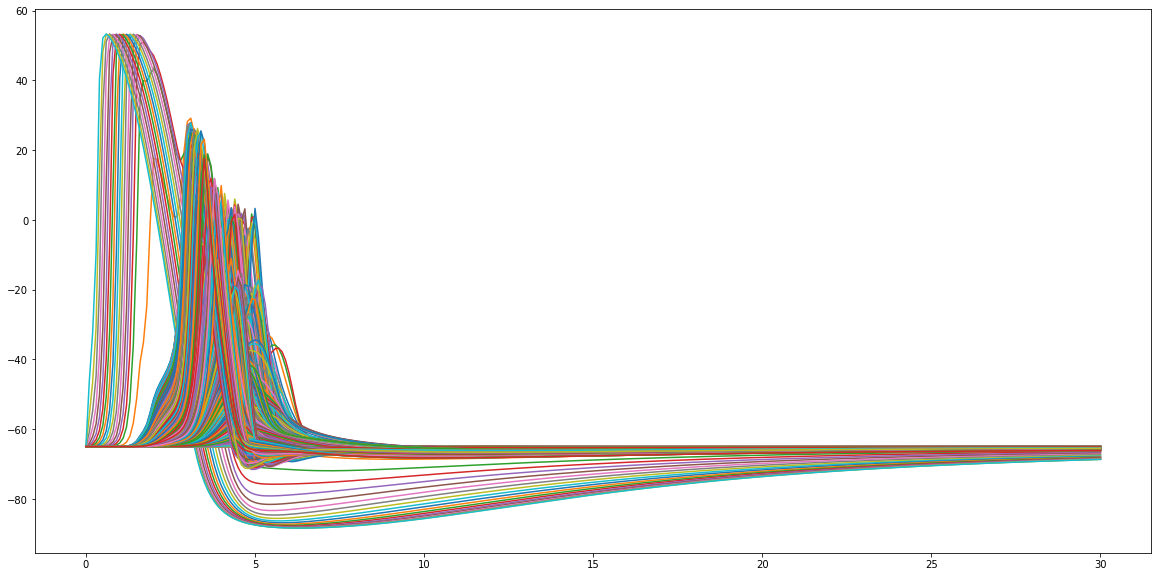

In [21]:
# voltages
plt.figure(figsize=(20,10))
for i in range(len(volts)):
    plt.plot(list(t), list(volts[i]))
plt.show()

In [15]:
from neuron import gui

In [8]:
len(volts)

974

In [9]:
# data
len(data)

14380

In [10]:
len(data)/len(volts)

14.763860369609857

In [11]:
data_keys

[[soma, 'cagk', 'o', soma(0.5)],
 [soma, 'cal', 'm', soma(0.5)],
 [soma, 'can', 'm', soma(0.5)],
 [soma, 'can', 'h', soma(0.5)],
 [soma, 'cat', 'm', soma(0.5)],
 [soma, 'cat', 'h', soma(0.5)],
 [soma, 'hd', 'l', soma(0.5)],
 [soma, 'kap', 'n', soma(0.5)],
 [soma, 'kap', 'l', soma(0.5)],
 [soma, 'kdr', 'n', soma(0.5)],
 [soma, 'na3', 'm', soma(0.5)],
 [soma, 'na3', 'h', soma(0.5)],
 [soma, 'na3', 's', soma(0.5)],
 [axon, 'kdr', 'n', axon(0.0263158)],
 [axon, 'kdr', 'n', axon(0.0789474)],
 [axon, 'kdr', 'n', axon(0.131579)],
 [axon, 'kdr', 'n', axon(0.184211)],
 [axon, 'kdr', 'n', axon(0.236842)],
 [axon, 'kdr', 'n', axon(0.289474)],
 [axon, 'kdr', 'n', axon(0.342105)],
 [axon, 'kdr', 'n', axon(0.394737)],
 [axon, 'kdr', 'n', axon(0.447368)],
 [axon, 'kdr', 'n', axon(0.5)],
 [axon, 'kdr', 'n', axon(0.552632)],
 [axon, 'kdr', 'n', axon(0.605263)],
 [axon, 'kdr', 'n', axon(0.657895)],
 [axon, 'kdr', 'n', axon(0.710526)],
 [axon, 'kdr', 'n', axon(0.763158)],
 [axon, 'kdr', 'n', axon(0.81578

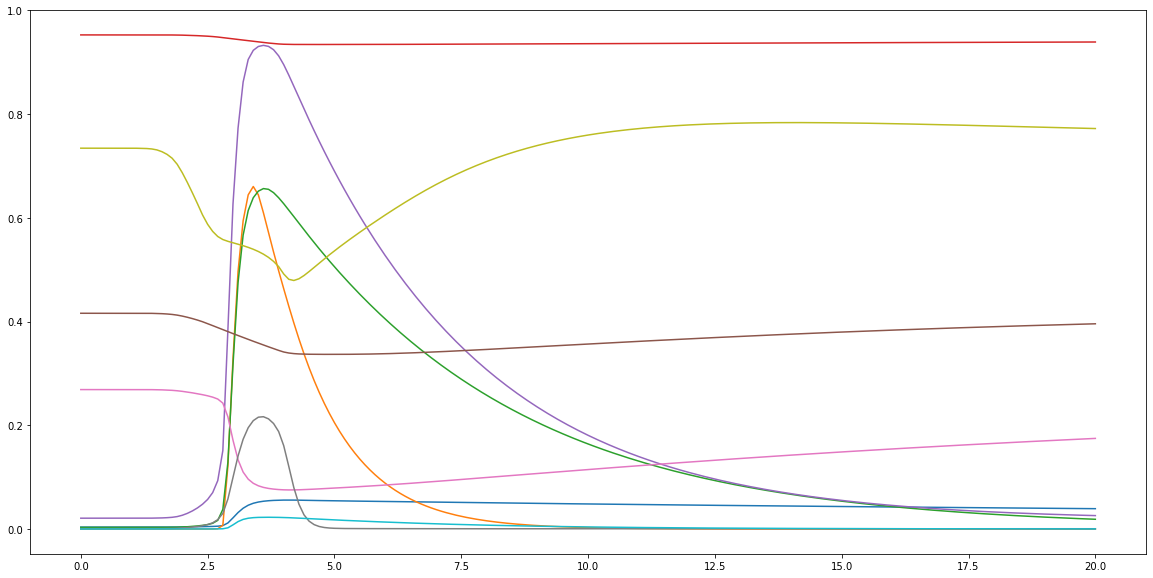

In [12]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.plot(list(t), list(data[i]))
plt.show()

## save data to file

In [13]:
'''
data = [list(_d) for _d in data]

dim_red_dir = '/home/trundle/Projects/NST-variation/dimensionality_reduction/data/87284/'
np.save(dim_red_dir + '87284_data', np.array(data+volts))
np.save(dim_red_dir + '87284_time', np.array(t))
'''

"\ndata = [list(_d) for _d in data]\n\ndim_red_dir = '/home/trundle/Projects/NST-variation/dimensionality_reduction/data/87284/'\nnp.save(dim_red_dir + '87284_data', np.array(data+volts))\nnp.save(dim_red_dir + '87284_time', np.array(t))\n"